In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input



In [11]:

# Load dataset
df = pd.read_csv("Global_Pollution_Analysis.csv")
df.head()


,Country,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD)
0,Hungary,2005,272.70,124.27,51.95,94802.83,158.14,5.30,41.11,37078.88,12.56,42.22,20972.96
1,Singapore,2001,86.72,60.34,117.22,56283.92,498.04,6.34,36.44,33128.20,5.23,137.25,34850.41
2,Romania,2016,91.59,83.36,121.72,56256.02,489.51,49.69,9.38,18803.46,13.15,124.47,57773.15
3,Cook Islands,2018,280.61,67.16,93.58,74864.73,145.18,8.91,18.97,9182.27,0.78,67.80,21837.51
4,Djibouti,2008,179.16,127.53,121.55,76862.06,40.38,14.93,34.00,39235.12,12.84,186.52,41379.37


In [12]:

# Drop missing values
df.dropna(inplace=True)

# Encode Country
le_country = LabelEncoder()
df['Country_Encoded'] = le_country.fit_transform(df['Country'])

# Normalize numeric columns
scaler = StandardScaler()
columns_to_scale = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
                    'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 'Energy_Recovered (in GWh)']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Feature Engineering
df['Energy_Consumption_Per_Capita (in MWh)'] = df['Energy_Consumption_Per_Capita (in MWh)'].fillna(
    df['Energy_Consumption_Per_Capita (in MWh)'].mean()
)


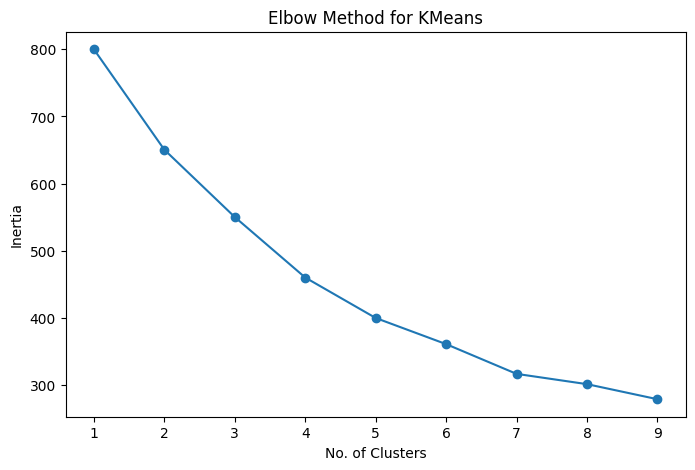

In [13]:

kmeans_features = df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index', 'Energy_Recovered (in GWh)']]
inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(kmeans_features)
    inertia.append(km.inertia_)

# Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for KMeans')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()

# Final KMeans model
kmeans = KMeans(n_clusters=3, random_state=0)
df['KMeans_Cluster'] = kmeans.fit_predict(kmeans_features)


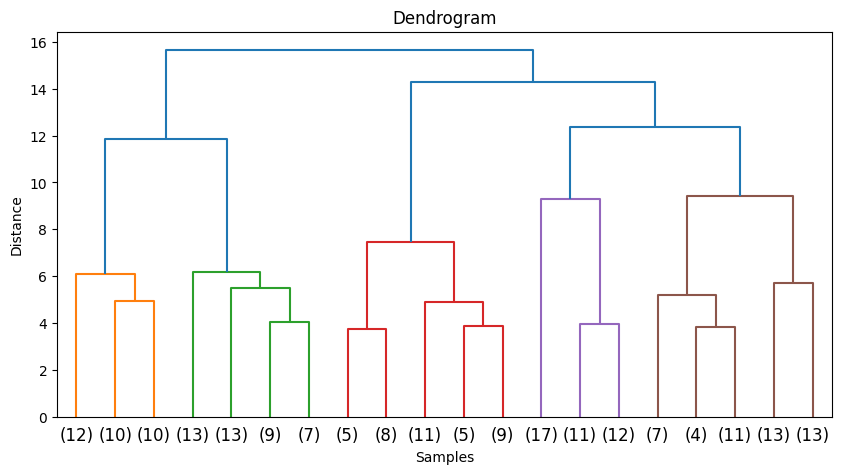

In [14]:

linked = linkage(kmeans_features, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=20)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Cluster'] = agg.fit_predict(kmeans_features)


In [15]:

features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
            'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 'Country_Encoded']
X = df[features]
y = df['Energy_Recovered (in GWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
R² Score: -0.131
MSE: 1.269
MAE: 1.03


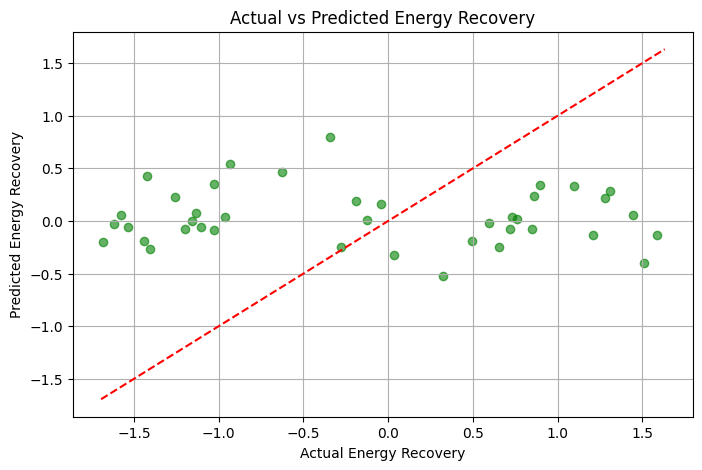

In [16]:

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R² Score:", round(r2, 3))
print("MSE:", round(mse, 3))
print("MAE:", round(mae, 3))

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='green', alpha=0.6)
plt.xlabel("Actual Energy Recovery")
plt.ylabel("Predicted Energy Recovery")
plt.title("Actual vs Predicted Energy Recovery")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid()
plt.show()
